In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde, norm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from scipy.stats import norm
from pypalettes import load_cmap
import geopandas as gpd
import contextily as ctx
from matplotlib.patches import FancyArrowPatch
import scipy.io as sio
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec

In [17]:
# Function to interpolate the colormap with cubic interpolation
def interpolate_cmap(cmap, num_interp_points):
    new_colors = cmap(np.linspace(0, 1,cmap.N))  
    new_cmap = LinearSegmentedColormap.from_list('my_interpolated_cmap', new_colors, N=num_interp_points)
    return new_cmap

In [18]:
basin = gpd.read_file('3Sbasin.shp')
 
basin = basin.to_crs(epsg=3857)
y_min, y_max = basin.total_bounds[1], basin.total_bounds[3]
x_max=basin.total_bounds[2]
x_min=basin.total_bounds[0]
print(f"Y min: {x_min}")
print(f"Y max: {x_max}")

Y min: 11793225.96486322
Y max: 12109451.992040318


In [19]:
# Cap values for each indicator (the ones used to normalize the values of each objective between 0 and 1 during the optimization)
maxtotalpro = 10.627501095537942e+06 #hp production
maxfirm = 3.207057309002500e+04 #firm hp
maxsed = 30 #sediment loads

In [20]:
# Reading optimization results for sluicing
filename = 'optimization_objectives_sluicing_final_1.txt'
data = np.loadtxt(filename)
all_data = data
'''
# Check whether all the solutions are pareto optimal solutions
is_pareto_efficient = np.ones(all_data.shape[0], dtype=bool)

for i, current_point in enumerate(all_data):
    for j, other_point in enumerate(all_data):
        # If we have more solutions with the same values we keep just one solution
        if (
            all(other_point < current_point) and 
            not np.array_equal(other_point, current_point)
        ):
            is_pareto_efficient[i] = False
            break

'''
fnew_unique = all_data


#fnew_unique = np.unique(fnew, axis=0)

# For the following plot, we locate sediment objective on the first column, hydro production on the second one, and firm hp on the third
a = fnew_unique[:, 0].copy()
b = fnew_unique[:, 1].copy()
fnew_unique[:, 0] = fnew_unique[:, 2]
fnew_unique[:, 1] = a
fnew_unique[:, 2] = b

fnew_unique_sluicing = fnew_unique
fnew_unique_sluicing[:, 0] = (1 - fnew_unique_sluicing[:, 0]) * maxsed;
fnew_unique_sluicing[:, 1] = (1 - fnew_unique_sluicing[:, 1]) * maxtotalpro*10**(-6) * 24 / 15
fnew_unique_sluicing[:, 2] = (1 - fnew_unique_sluicing[:, 2]) * maxfirm*24*10**(-3)
print(f"Pareto-efficient points:\n{fnew_unique}")

Pareto-efficient points:
[[  9.0132      14.7984637  126.3267571 ]
 [  9.02133     14.78984267 127.30734694]
 [  9.02616     14.78093257 122.59913024]
 [  8.48697     14.70052065 234.24474867]
 [ 10.50483     14.21332199 299.20382275]
 [  9.32919     14.59691526 199.89023765]
 [  9.77088     14.27866837 327.6024435 ]
 [ 10.46562     14.29638654 238.62045766]
 [ 10.35057     14.21301592 256.66823681]
 [ 10.38174     14.33819938 249.74638088]
 [ 10.1439      13.23491173 306.63906441]
 [ 10.02711     13.21829882 306.63906441]
 [ 10.33347     14.3106869  270.05628997]
 [  8.80194     14.83621258  99.99784285]
 [  8.79978     14.83063527 107.31993953]
 [  9.03921     14.78647588 103.33523496]
 [  9.97014     13.33015114 308.38088138]
 [  7.89333     14.67137579 325.09632064]
 [ 10.73184     14.25306034 308.22078508]
 [  9.94095     14.4135101  299.09991409]
 [  9.80727     14.41719997 324.96932117]
 [  7.89894     14.69115144 271.46482954]
 [  9.30474     14.32014113 316.82673094]
 [  9.132

In [21]:
# Find the Row Index for the Maximum of Each Column
max_sediment_index = np.argmax(fnew_unique_sluicing[:, 0])  # Index of the maximum value in the first column (sediment)
max_hydro_index = np.argmax(fnew_unique_sluicing[:, 1])     # Index of the maximum value in the second column (total hp)
max_firm_index = np.argmax(fnew_unique_sluicing[:, 2])      # Index of the maximum value in the third column (firm)


print(f"Maximum of sediment: Index {max_sediment_index}")
print(f"Maximum of hydro: Index {max_hydro_index}")
print(f"Maximum of firm: Index {max_firm_index}")

Maximum of sediment: Index 88
Maximum of hydro: Index 194
Maximum of firm: Index 103


In [22]:
# Indices of the fnew_unique_flush matrix used for plotting the Pareto frontier
'''
Obtained simulating VIRes_CASCADE with each optimal pareto optimal reservoir parametrization, and assessing which solution includes coordination and which do not
'''

index_firm_maxsluicing = np.array([103], dtype=np.uint8)
index_sediment_maxsluicing = np.array([88], dtype=np.uint16)
index_hydro_maxsluicing = np.array([194], dtype=np.uint16)
indices_other = np.array([3,6,10,11,16,17,21,24,25,26,35,36,39,40,44,46,50,51,52,55,56,64,79,80,81,82,83,86,92,93,131,138,139,145,154,155,158,159,160,161,162,165,167,168,180,184,192,193,194,195,196,197,209,210,219,220], dtype=np.uint16) 
indices_plot= np.array([0,1,2,4,5,7,8,9,12,13,14,15,18,19,20,22,23,27,28,29,30,31,32,33,34,37,38,41,42,43,45,47,48,49,53,54,57,58,59,60,61,62,63,65,66,67,68,69,70,71,72,73,74,75,76,77,78,84,85,87,88,89,90,91,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,132,133,134,135,136,137,140,141,142,143,144,146,147,148,149,150,151,152,153,156,157,163,164,166,169,170,171,172,173,174,175,176,177,178,179,181,182,183,185,186,187,188,189,190,191,198,199,200,201,202,203,204,205,206,207,208,211,212,213,214,215,216,217,218,221,222,223,224,225],
                    dtype=np.uint16)

In [23]:
# Historical values of the three objectives
# Obtained simulating VICRes-CASCADE from 2008 to 2022 with the original water rule curve
historicalpro = 13.31259859521568
historicalfirm = 167.6655259864105
historicalsedload = 7.73458307692526

/var/folders/m7/hdv2wgx56_393jmgypswfryr0000gn/T/ipykernel_15473/805987564.py:122: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(row.geometry.x, row.geometry.y,
/var/folders/m7/hdv2wgx56_393jmgypswfryr0000gn/T/ipykernel_15473/805987564.py:122: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(row.geometry.x, row.geometry.y,
/var/folders/m7/hdv2wgx56_393jmgypswfryr0000gn/T/ipykernel_15473/805987564.py:122: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument

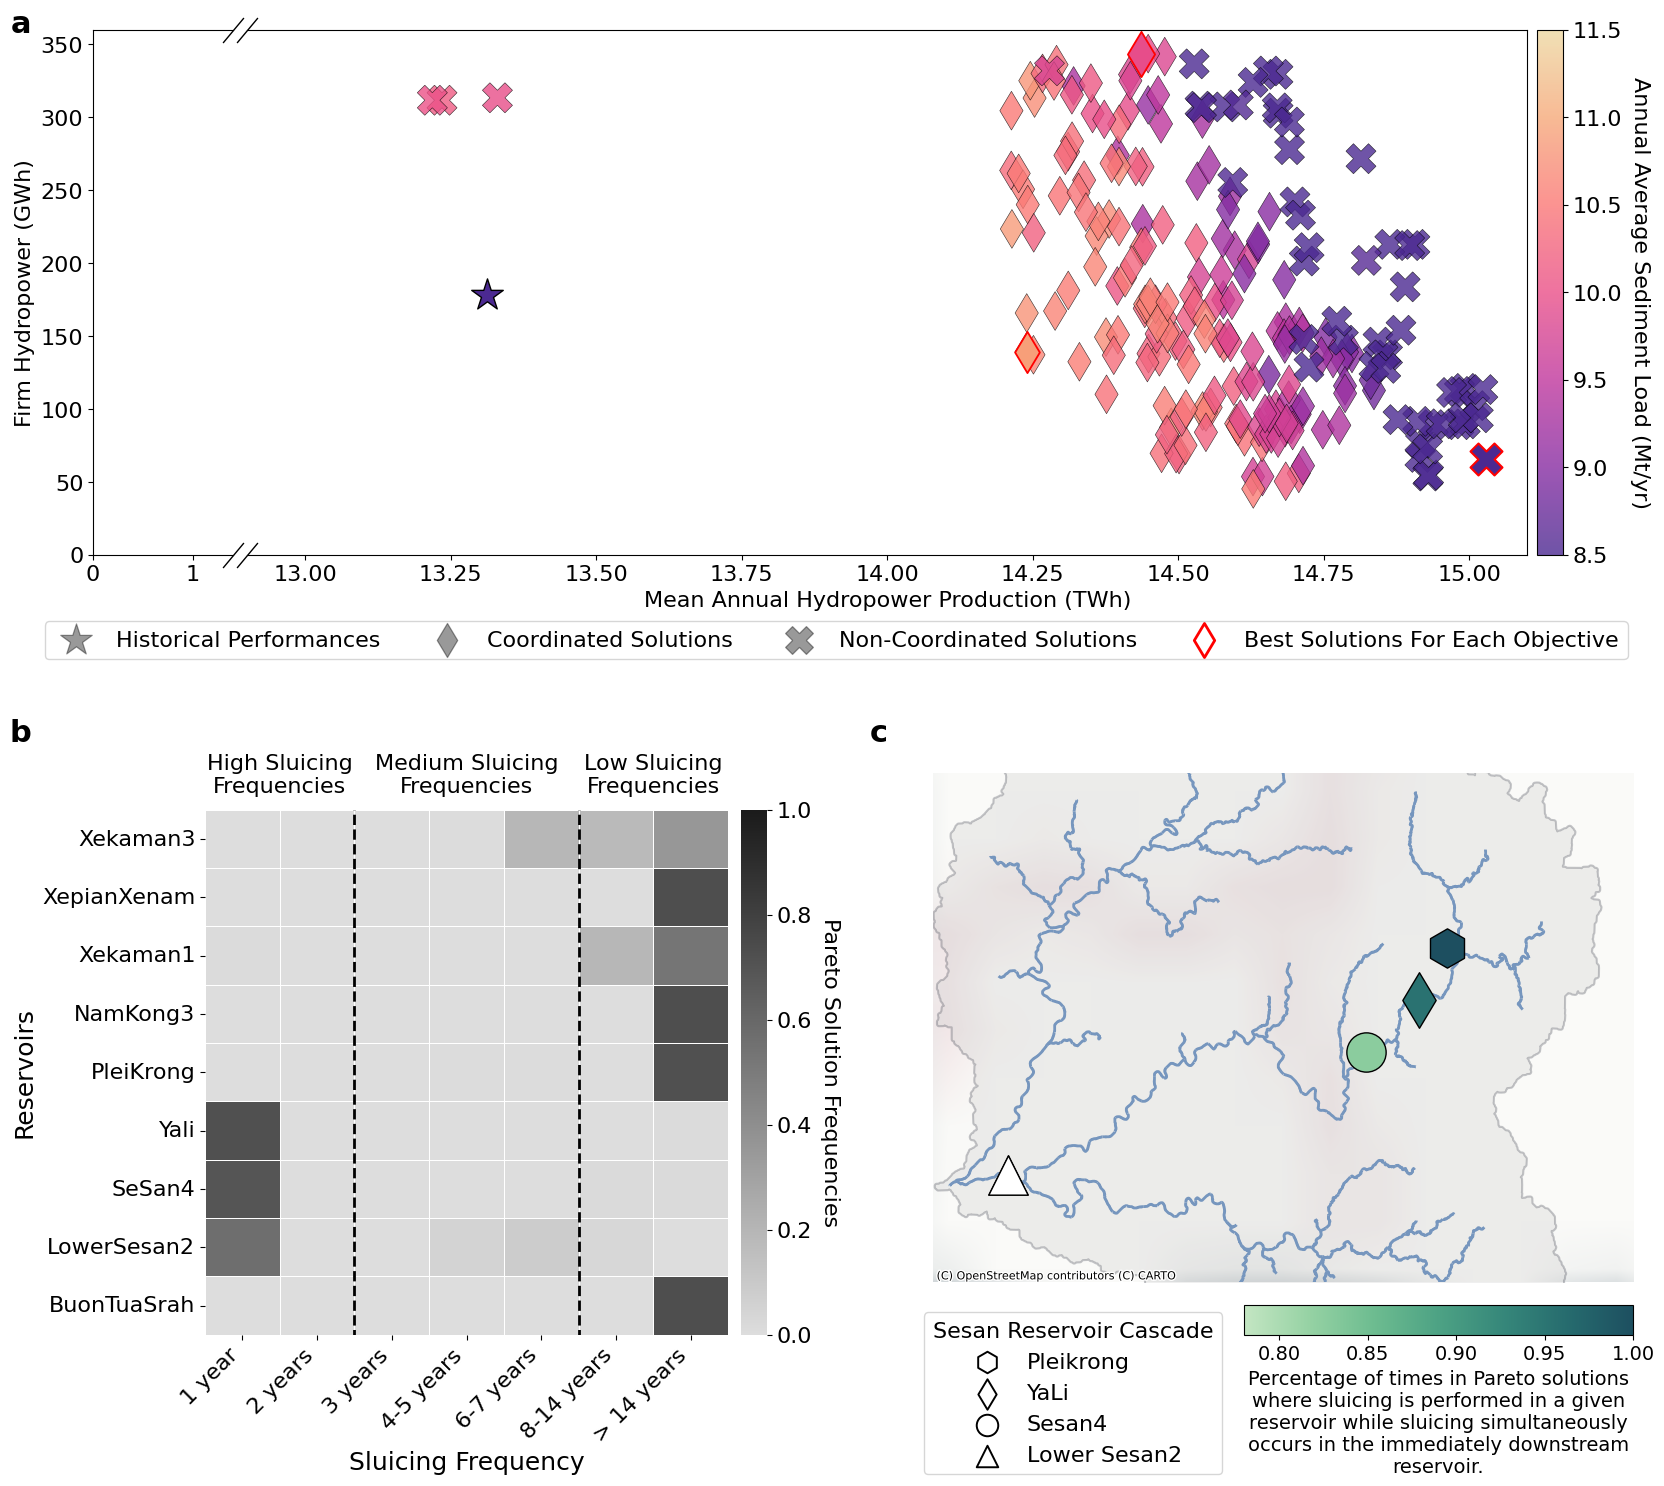

In [24]:
def plot1(ax):
    cmap = load_cmap("borg")
    cmap=cmap.reversed()
    cmap = interpolate_cmap(cmap, 1000)
    # Load data from CSV files
    freq = pd.read_csv('frequencies.csv', header=None)
    freq=freq.T
    # Setting columns names
    freq.columns = ['1 year', '2 years' ,'3 years' , '4-5 years', '6-7 years', '8-14 years', '> 14 years']

    # Setting rows names
    values = ['Xekaman3','XepianXenam','Xekaman1','NamKong3','PleiKrong','Yali','SeSan4', 'LowerSesan2', 'BuonTuaSrah']
    freq.index = values
    
    

    
    ax=sns.heatmap(freq, annot=False, cmap=cmap, linewidths=.6,cbar_kws={'shrink': 1, 'aspect': 20, 'pad': 0.02})
    
    cbar = ax.collections[0].colorbar
    cbar.mappable.set_clim(0,1)
    cbar.ax.set_ylabel('Pareto Solution Frequencies', rotation=270, fontsize=16,labelpad=20)
    cbar.ax.tick_params(labelsize=16)
    
    freq_high = 2
    freq_low = 4
    freq_never = 6
    
    xmin, xmax = ax.get_xlim()  
    ymin, ymax = ax.get_ylim()  
    
    ax.axvline(2, -1, 2, color='black', linestyle='--', linewidth=2) 
    ax.axvline(5, -1, 2, color='black', linestyle='--', linewidth=2) 
    
    ax.text(1, -0.3, 'High Sluicing\nFrequencies', ha='center', fontsize=16)
    ax.text(3.5, -0.3, 'Medium Sluicing\nFrequencies', ha='center', fontsize=16)
    
    ax.text(6, -0.3, 'Low Sluicing\nFrequencies', ha='center', fontsize=16)

    ax.set_xticks(range(len(freq.columns)))
    ax.set_xticklabels(freq.columns, rotation=45, fontsize=16)
    ax.set_yticks(range(len(freq.index)))
    ax.set_yticklabels(freq.index, fontsize=16,ha='center')
    # Titles
    ax.set_xlabel('Sluicing Frequency', fontsize=18)
    ax.set_ylabel('Reservoirs', fontsize=18)
    
    ax.set_xticks(np.arange(len(freq.columns)) + 0.5)
    ax.set_xticklabels(freq.columns, rotation=45, fontsize=16, ha='right')

    ax.set_yticks(np.arange(len(freq.index)) + 0.5)
    ax.set_yticklabels(freq.index, fontsize=16, va='center',ha='right')

def plot2(ax):
    reservoirs = gpd.read_file('reservoir.shp')
    basin = gpd.read_file('3Sbasin.shp')
    rivernetwork = gpd.read_file('rivernetwork.shp')

    # Project everything to Web Mercator (EPSG:3857) for use with contextily
    reservoirs = reservoirs.to_crs(epsg=3857)
    basin = basin.to_crs(epsg=3857)
    rivernetwork = rivernetwork.to_crs(epsg=3857)

    
    selected_reservoirs = ['Pleikrong', 'YaLi', 'Sesan4', 'LowerSesan2']
    selected_lss = ['LowerSesan2']

    # Filter the selected reservoirs and calculate the percentages
    selected_reservoirs_data = reservoirs[reservoirs['name'].isin(selected_reservoirs)]
    lowersesan=reservoirs[reservoirs['name'].isin(selected_lss)]
    labels = selected_reservoirs_data['name'].tolist() 
    # Load data from CSV files
    frequenze_df = pd.read_csv('histogram_frequencies.csv', header=None)
    frequenze = frequenze_df.values.flatten()
    
    frequenze = np.append(frequenze, 0)

    cmap = load_cmap("BluGrn")
    cmap = interpolate_cmap(cmap, 1000)
    # Generate colors based on the values of 'frequencies'
    norm = mcolors.Normalize(vmin=0.77, vmax=max(frequenze))
    colors = cmap(norm(frequenze))

    # Define the categories on the x-axis
    categorie = ['PleiKrong', 'Yali', 'Sesan4']
    scatter_1 = ax.scatter(0,
                            0,
                            s=240, c='white', alpha=1,
                            marker='h',edgecolors='black',linewidth=1.4, label='Pleikrong')
    
    scatter_2 = ax.scatter(0,
                            0,
                            s=240, c='white', alpha=1,
                            marker='d',edgecolors='black',linewidth=1.4, label='YaLi')
    
    scatter_3 = ax.scatter(0,
                            0,
                            s=240, c='white', alpha=1,
                            marker='o',edgecolors='black',linewidth=1.4, label='Sesan4')
    
    scatter_4 = ax.scatter(0,
                            0,
                            s=240, c='white', alpha=1,
                            marker='^',edgecolors='black',linewidth=1.4, label='Lower Sesan2')
    ax.axis('off')
    mark=['h','d','o','^']
    cmap1 = load_cmap("Classic_Gray_5")
    cmap1 = interpolate_cmap(cmap1, 1000)
    basin.plot(ax=ax, facecolor=cmap1(0.99),alpha=0.3, edgecolor=cmap1(0.5),linewidth=1.5)
    
    prova=['Pk','YL','S4','Lss2']
    #srepok.plot(ax=ax, facecolor="none", edgecolor="green", label='Srepok Sub-basin')
    #sesan.plot(ax=ax, facecolor="none", edgecolor="orange", label='Sesan Sub-basin')
    #sekong.plot(ax=ax, facecolor="none", edgecolor="purple", label='Sekong Sub-basin')
    cmap2 = load_cmap("Bmsurface")
    rivernetwork.plot(ax=ax, color=cmap2(0.5),linewidth=2,zorder=1)
    
    
    i=0
    
    for idx, row in selected_reservoirs_data.iterrows():
        scatter = ax.scatter(row.geometry.x, row.geometry.y, 
               marker=mark[i], s=800, c=colors[i],cmap=cmap, edgecolor='black')
        #ax.text(row.geometry.x, row.geometry.y, prova[i], fontsize=14, ha='left', va='bottom')
        i=i+1
    scatter = ax.scatter(lowersesan.geometry.x, lowersesan.geometry.y, 
               marker='^', s=800, c='white', edgecolor='black')
    #ax.set_title('Sesan Reservoir Cascade',fontsize=16)
    ax.set_aspect('equal')
    ctx.add_basemap(ax, crs=reservoirs.crs.to_string(),source=ctx.providers.CartoDB.Positron)
    #ctx.add_basemap(ax, crs=reservoirs.crs.to_string(),source=ctx.providers.NASAGIBS.ASTER_GDEM_Greyscale_Shaded_Relief)
    #ctx.add_basemap(ax, crs=reservoirs.crs.to_string(),source=ctx.providers.NASAGIBS.BlueMarble)
    #ctx.add_basemap(ax, crs=reservoirs.crs.to_string(),source=ctx.providers.USGS.USTopo)
    ax.set_ylim((1481903,1690833))
    ax.set_xlim((11793225,12080451))
    
    ax.axis('off')
    
    

    # colormap configuration
    norm = plt.Normalize(vmin=0.78, vmax=1)
    
    cbaxes = fig.add_axes([0.822, 0.48006, 0.278, 0.02]) 
    
    divider = make_axes_locatable(ax)
    #cax = divider.append_axes("bottom", size="5%", pad=0.5)  # posizioniamo sotto e aumentiamo il pad per spazio testo

    # colormap
    cb = plt.colorbar(mappable=plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbaxes, orientation='horizontal')
    cb.set_label('Percentage of times in Pareto solutions\nwhere sluicing is performed in a given\nreservoir while sluicing simultaneously\noccurs in the immediately downstream\nreservoir.', fontsize=14)
    cb.ax.tick_params(labelsize=14)
    #cb.ax.set_position([1, 0.6, 0.2, 0.1])
    
    text_x = (ax.get_position().x0 + ax.get_position().x1) / 2
    text_y = cbaxes.get_position().y0 - 0.05  # regoliamo la posizione y del testo
    #fig.text(text_x, text_y, 'Il colore indica la frequenza di sluicing coordinato.', ha='center', fontsize=12)

    legend = ax.legend(fontsize=16,loc='lower center', bbox_to_anchor=(0.2, -0.4))
    legend.set_title('Sesan Reservoir Cascade',prop={'size': 16})


   

def plot3(ax,a):
    
    cmap = load_cmap("ag_Sunset")
    cmap = interpolate_cmap(cmap, 1000)
    #cmap=cmap.reversed()
    
    

    color_values = fnew_unique_sluicing[:, 0]
    color_min = 8.5
    color_max = 11.5
    color_values = np.clip(color_values, color_min, color_max)
    norm = mcolors.Normalize(vmin=8.5, vmax=12)
    specific_value4 = historicalsedload
    specific_value5 = color_values[index_sediment_maxsluicing]
    specific_value6 = color_values[index_hydro_maxsluicing]
    specific_value7 = color_values[index_firm_maxsluicing]
    

    # Normalize the specific value based on the colormap range
    norm = mcolors.Normalize(vmin=color_min, vmax=color_max)
    normalized_value4 = norm(specific_value4)
    normalized_value5 = norm(specific_value5)
    normalized_value6 = norm(specific_value6)
    normalized_value7 = norm(specific_value7)
    

    fixed_color4 = cmap(normalized_value4)
    fixed_color5 = cmap(normalized_value5)
    fixed_color6 = cmap(normalized_value6)
    fixed_color7 = cmap(normalized_value7)
    

    c = color_values

    scatter_1 = ax.scatter(-10,
                            0,
                            s=570, c='black', alpha=0.4,
                            marker='*',edgecolors='black',linewidth=0.9, label='Historical Performances')

    scatter_2 = ax.scatter(-10,
                                0,
                                s=300, c='black', alpha=0.4,
                                marker='d',edgecolors='black',linewidth=0.9, label='Coordinated Solutions')

    scatter_3 = ax.scatter(-10,
                            0,
                            s=400, c='black', alpha=0.4,
                            marker='X',edgecolors='black',linewidth=0.9, label='Non-Coordinated Solutions')

    scatter_4 = ax.scatter(-10, 0,
                                    s=300, c='white', alpha=1, marker='d',edgecolors='red',linewidth=2,
                                    label='Best Solutions For Each Objective')
    
    scatter1 = ax.scatter(fnew_unique_sluicing[indices_plot, 1], fnew_unique_sluicing[indices_plot, 2], s=390, c=c[indices_plot],cmap=cmap,norm=norm,marker='d',alpha=0.8, edgecolor='black', linewidth=0.4)
    scatter2 = ax.scatter(fnew_unique_sluicing[indices_other, 1], fnew_unique_sluicing[indices_other, 2], s=470, c=c[indices_other],cmap=cmap,norm=norm, marker='X',alpha=0.8, edgecolor='black', linewidth=0.4)
    
    scatter3 = ax.scatter(fnew_unique_sluicing[index_sediment_maxsluicing, 1], fnew_unique_sluicing[index_sediment_maxsluicing, 2], s=440, facecolor=fixed_color5,cmap=cmap,marker='d', edgecolor='red',linewidth=1.3)
    #ax.plot(fnew_unique_sluicing[indice_sediment_maxsluicing, 1], fnew_unique_sluicing[indice_sediment_maxsluicing, 2], 'o', markersize=12, linewidth=1.7, markerfacecolor='none', markeredgecolor='r')
    scatter6 = ax.scatter(fnew_unique_sluicing[index_hydro_maxsluicing, 1], fnew_unique_sluicing[index_hydro_maxsluicing, 2], s=530, facecolor=fixed_color6,cmap=cmap, marker='X', edgecolor='red',linewidth=1.5)
    #ax.plot(fnew_unique_sluicing[indice_hydro_maxsluicing, 1], fnew_unique_sluicing[indice_hydro_maxsluicing, 2], 's', markersize=12, linewidth=1.7, markerfacecolor='none', markeredgecolor='r')

    scatter7 = ax.scatter(fnew_unique_sluicing[index_firm_maxsluicing, 1], fnew_unique_sluicing[index_firm_maxsluicing, 2], s=530, facecolor=fixed_color7, cmap=cmap, marker='d', edgecolor='red',linewidth=1.3)
    #ax.plot(fnew_unique_flush[indice_firm_maxsluicing, 1], fnew_unique_flush[indice_firm_maxsluicing, 2], 's', markersize=12, linewidth=1.7, markerfacecolor=l[indice_firm_maxsluicing], markeredgecolor='red')

    scatter4 = ax.scatter(historicalpro, historicalfirm, s=570, facecolor=fixed_color4,cmap=cmap, marker='*', edgecolor='black')
    #ax.plot(fnew_unique_flush[indicecompromize2flush, 1], fnew_unique_flush[indicecompromize2flush, 2], 'o', markersize=12, linewidth=1.7, markerfacecolor='none', markeredgecolor=[0.0588, 0.3608, 0.0314])
    if a == 0:
        ax.set_ylabel('Firm Hydropower (GWh)', fontsize=16)
        ax.set_ylim([0, 15000 * 10**(-3) * 24])
        ax.tick_params(axis='both', which='major', labelsize=16)
    if a == 1:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
    
        cb = plt.colorbar(scatter1, cax=cax)
        cb.mappable.set_clim(color_min, color_max)
        cb.set_label('Annual Average Sediment Load (Mt/yr)', fontsize=16, rotation=270, labelpad=20)
        cb.ax.tick_params(labelsize=16)

        ax.set_xlabel('Mean Annual Hydropower Production (TWh)', fontsize=16)
        
    #brokenaxes(xlims=((0, 1), (13, 15.1)), hspace=0.05)  
    
        ax.set_xlim([13 , 15.1])
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_yticks([])  # Nasconde i tick sull'asse y
        ax.set_yticklabels([]) 
    
        legend = ax.legend(fontsize=16,loc='lower center', bbox_to_anchor=(0.46, -0.22), ncol=4)
        legend.set_title(None)


#fig = plt.figure(figsize=(14, 15))


fig = plt.figure(figsize=(14, 15))

left = 0.08
bottom = 0.48
width = 0.45
height = 0.35

ax1 = fig.add_axes([left, bottom, width, height])
plt.sca(ax1)  
plot1(ax1)

left = 0.6
bottom = 0.45
width = 0.5
height = 0.47

ax2 = fig.add_axes([left, bottom, width, height])
plt.sca(ax2)  
plot2(ax2)

left1 = 0.0   
bottom = 1
width1 = 0.1
height = 0.35
ax3_1 = fig.add_axes([left1, bottom, width1, height])

left2 = 0.11 
width2 = 0.94
ax3_2 = fig.add_axes([left2, bottom, width2, height])


plt.sca(ax3_1)
plot3(ax3_1,0)
ax3_1.set_xlim(0, 1.4) 

plt.sca(ax3_2)
plot3(ax3_2,1)
ax3_2.set_xlim(12.9, 15.1)  


ax3_1.spines['right'].set_visible(False)
ax3_2.spines['left'].set_visible(False)

d = 1.2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=18,
            linestyle='none',color='k', mec='k', mew=1, clip_on=False)
ax3_1.plot([1, 1], [0, 1], transform=ax3_1.transAxes, **kwargs)
ax3_2.plot([0, 0], [0, 1], transform=ax3_2.transAxes, **kwargs)


ax3_2.text(12.53, 355, 'a', fontsize=22, ha='right', fontweight='bold')
ax3_2.text(12.53, -150, 'b', fontsize=22, ha='right', fontweight='bold')
ax3_2.text(14, -150, 'c', fontsize=22, ha='right', fontweight='bold')


plt.savefig('Figure5.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()
